# 🐦 BIRD RECOGNITION

In [42]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
import matplotlib.pyplot as plt

### CHARGEMENT DES DONNÉES

In [ ]:
dataset_path = "images"

# 80% entraînement, 20% test
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 3422 files belonging to 20 classes.
Using 2738 files for training.
Found 3422 files belonging to 20 classes.
Using 684 files for validation.


### IMPORTATION DU MODELE EFFICIENTNETB3

In [ ]:
base_model = EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# On défreeze les 35 dernières couches
for layer in base_model.layers[:-35]:
    layer.trainable = False

### AJOUT DES COUCHES POUR LA CLASSIFICATION

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) # stabilisation de l'apprentissage
x = Dense(128, activation='relu')(x) # couche fully connected
x = Dropout(0.30)(x)  # 30% des neurones sont désactivés pendant l'entraînement
x = BatchNormalization()(x)
predictions = Dense(20, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### ENTRAINEMENT DU MODÈLE

In [47]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[
    EarlyStopping(patience=3, restore_best_weights=True)
])

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 91s 536ms/step - accuracy: 0.7584 - loss: 0.9118 - val_accuracy: 0.9620 - val_loss: 0.2672
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9850 - loss: 0.0739 - val_accuracy: 0.9854 - val_loss: 0.1033
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9894 - loss: 0.0564 - val_accuracy: 0.9795 - val_loss: 0.0843
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9966 - loss: 0.0200 - val_accuracy: 0.9825 - val_loss: 0.0825
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9925 - loss: 0.0303 - val_accuracy: 0.9810 - val_loss: 0.0839
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9945 - loss: 0.0303 - val_accuracy: 0.9839 - val_loss: 0.0829
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9968 - loss: 0.0136 - val_accuracy: 0.9868 - val_loss: 0.0756
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9976 - loss: 0.0107 - val_accu

### ÉVALUATION DES PERFORMANCES

In [48]:
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy : {accuracy*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9915 - loss: 0.0549
Accuracy : 98.83%


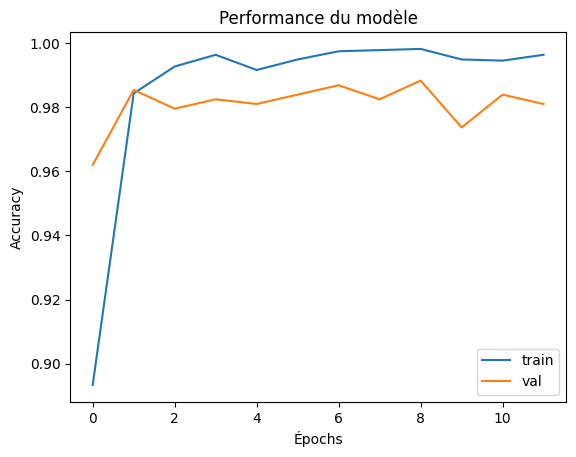

In [49]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Performance du modèle")
plt.show()

### SAUVEGARDE DU MODÈLE

In [ ]:
model.save("E-30-35-98,83.keras")
# EfficientNetB3, 30% de dropout, 35 dernières couches dégelées & 98,83% d'accuracy

Modèle sauvegardé sous le nom 'E-30-35-98,83.keras'
